In [2]:
import pandas as pd
import numpy as np

from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Ensure nltk dependencies are available
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Load dataset
train = pd.read_csv('../date/train_data_cleaned.csv')
test = pd.read_csv('../date/test_data_cleaned.csv')
val = pd.read_csv('../date/val_data_cleaned.csv')

In [5]:
from nltk.stem import LancasterStemmer

# Initialize the Lancaster stemmer
stemmer = LancasterStemmer()

# Preprocessing function with Lancaster stemming
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [stemmer.stem(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)


In [6]:
# Apply preprocessing
for df in [train, val, test]:
    df['processed_text'] = df['text'].apply(preprocess_text)
    df['processed_title'] = df['title'].apply(preprocess_text)
    df['combined_text'] = df['processed_title'] + " " + df['processed_text']

In [7]:
# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['combined_text'])

X_train = pad_sequences(tokenizer.texts_to_sequences(train['combined_text']), maxlen=100, padding='post')
X_val = pad_sequences(tokenizer.texts_to_sequences(val['combined_text']), maxlen=100, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(test['combined_text']), maxlen=100, padding='post')

In [8]:
# Train Word2Vec model
w2v_model = Word2Vec(sentences=[text.split() for text in train['combined_text']], vector_size=100, window=5, min_count=1, workers=4)

# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [9]:
# Build RNN Model for Sequence Embedding
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=100, trainable=False),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.4),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(100, activation='relu')  # Output a vector representation instead of classification
])

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [10]:
from tensorflow.keras.optimizers import AdamW

optimizer = AdamW(learning_rate=0.001, weight_decay=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     3,223,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,223,800 (12.30 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,223,800 (12.30 MB)

In [11]:
from sklearn.metrics import silhouette_score

# Generate embeddings for sequences
sequence_embeddings = model.predict(X_train)

# Function to compute silhouette scores for different numbers of clusters
def find_optimal_clusters(embeddings, max_clusters=10):
    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)
        score = silhouette_score(embeddings, cluster_labels)
        silhouette_scores.append(score)
        print(f"Silhouette Score for {n_clusters} clusters: {score:.4f}")
    return silhouette_scores

# Compute silhouette scores for sequence embeddings
max_clusters = 10
silhouette_scores = find_optimal_clusters(sequence_embeddings, max_clusters=max_clusters)





151/151 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step
Silhouette Score for 2 clusters: 0.1271
Silhouette Score for 3 clusters: 0.1016
Silhouette Score for 4 clusters: 0.1492
Silhouette Score for 5 clusters: 0.1515
Silhouette Score for 6 clusters: 0.1355
Silhouette Score for 7 clusters: 0.1406
Silhouette Score for 8 clusters: 0.1474
Silhouette Score for 9 clusters: 0.1528
Silhouette Score for 10 clusters: 0.1396


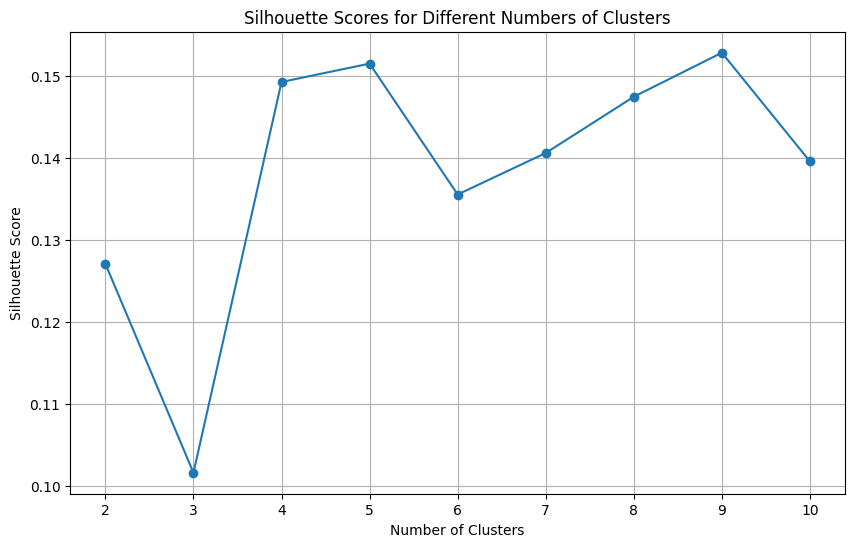

In [12]:
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

In [13]:
# K-Means Clustering on Sequence Embeddings with Optimal Clusters
optimal_clusters = np.argmax(silhouette_scores) + 2  # Adding 2 because cluster range starts at 2
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
sequence_labels = kmeans.fit_predict(sequence_embeddings)

# Visualize Sequence Clusters with t-SNE
sequence_tsne = TSNE(n_components=2, random_state=42)
sequence_embeddings_2d = sequence_tsne.fit_transform(sequence_embeddings)

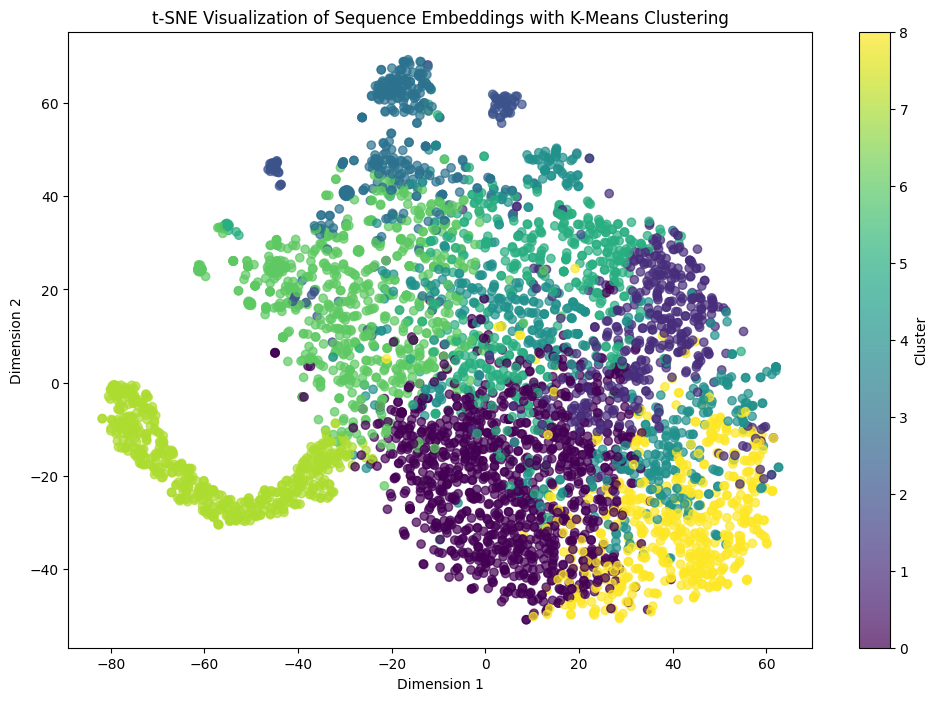

In [14]:
plt.figure(figsize=(12, 8))
plt.scatter(sequence_embeddings_2d[:, 0], sequence_embeddings_2d[:, 1], c=sequence_labels, cmap='viridis', alpha=0.7)
plt.colorbar(label="Cluster")
plt.title('t-SNE Visualization of Sequence Embeddings with K-Means Clustering')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [15]:
# Analyze Clusters
clusters = {}
words = w2v_model.wv.index_to_key
for word, cluster in zip(words, sequence_labels):
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(word)

# Print Top Words in Each Cluster
for cluster_id, cluster_words in clusters.items():
    print(f"Cluster {cluster_id+1}:")
    print(", ".join(cluster_words[:20]))  # Show top 20 words
    print()

Cluster 3:
trump, support, think, cent, appear, lot, cur, program, oth, kind, seen, account, fut, arm, judg, saf, respect, ukrain, gold, ultim

Cluster 9:
said, campaign, am, govern, know, sand, rac, law, believ, milit, deb, sign, ask, not, don, good, conserv, court, mean, put

Cluster 4:
clinton, presid, ev, republ, elect, year, democr, candid, first, two, hous, publ, includ, fin, man, sint, end, let, memb, tru

Cluster 6:
stat, lik, com, get, form, perc, wel, talk, deal, system, among, plac, hist, hap, black, kil, might, problem, already, though

Cluster 2:
us, peopl, pol, tak, work, going, see, thing, 2016, quest, fact, accord, maj, commit, investig, lat, every, nev, john, viol

Cluster 5:
new, mak, country, want, whit, nee, mil, issu, op, forc, group, person, anoth, syr, cas, bas, becom, follow, numb, diff

Cluster 7:
would, vot, hil, nat, obam, party, day, war, world, attack, bil, email, point, policy, chang, look, ear, pow, mov, secret

Cluster 1:
on, say, tim, off, act, could, r

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step
Test Accuracy: 0.6822

Test Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.81      0.73       320
           1       0.71      0.54      0.61       281

    accuracy                           0.68       601
   macro avg       0.69      0.67      0.67       601
weighted avg       0.69      0.68      0.68       601



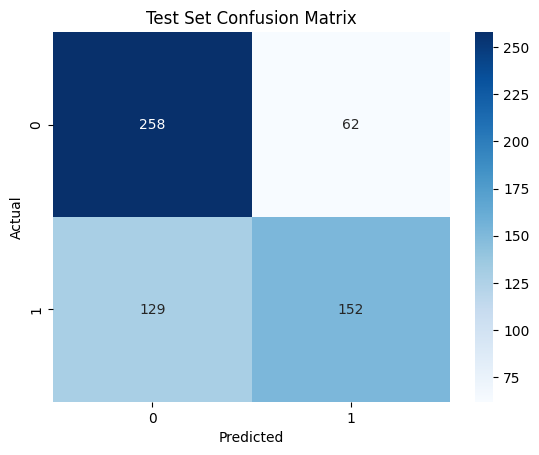

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ensure that true labels are available in the test set
if 'label' in test.columns:
    true_test_labels = test['label'].values  # Replace with actual labels if available
    test_embeddings = model.predict(X_test)  # Generate embeddings for test data

    # Predict clusters for the test set
    test_predicted_labels = kmeans.predict(test_embeddings)  # Cluster labels for test set

    # Map predicted clusters to actual labels using the cluster mapping from training
    test_mapped_labels = np.array([cluster_mapping.get(cluster, -1) for cluster in test_predicted_labels])

    # Filter out any unmapped clusters (if any exist)
    valid_indices = test_mapped_labels != -1
    valid_true_labels = true_test_labels[valid_indices]
    valid_mapped_labels = test_mapped_labels[valid_indices]

    # Calculate accuracy for the test set
    test_accuracy = accuracy_score(valid_true_labels, valid_mapped_labels)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("\nTest Classification Report:")
    print(classification_report(valid_true_labels, valid_mapped_labels))

    # Confusion Matrix for the test set
    test_conf_matrix = confusion_matrix(valid_true_labels, valid_mapped_labels)
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(valid_true_labels), yticklabels=np.unique(valid_true_labels))
    plt.title('Test Set Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print("No labels available for accuracy calculation on the test set.")


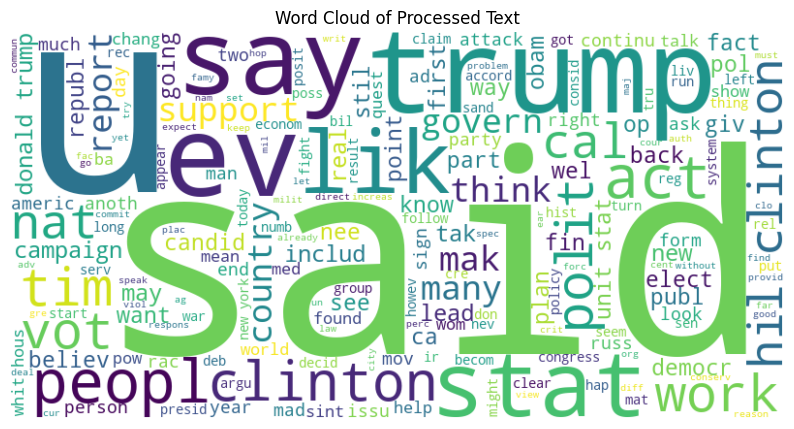

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(train['processed_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Processed Text")
plt.show()
